### [Introduction to Brian part 2: Synapses](https://brian2.readthedocs.io/en/stable/resources/tutorials/2-intro-to-brian-synapses.html)

In [1]:
from brian2 import *

#### The simplest Synapse

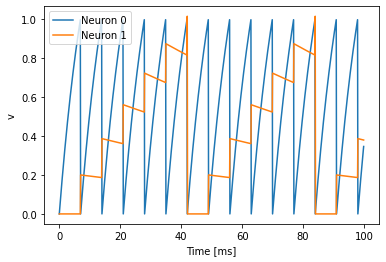

In [2]:
start_scope()

eqs = '''
dv/dt = (I-v)/tau : 1
I : 1
tau : second
'''
G = NeuronGroup(2, eqs, threshold='v>1',
               reset='v=0', method='exact')
G.I = [2, 0]
G.tau = [10, 100]*ms

# Comment these two lines out to see what happens without Synapses
S = Synapses(G, G, on_pre="v_post+=0.2")
S.connect(i=0, j=1)

M = StateMonitor(G, 'v', record=True)
run(100*ms)
plot(M.t/ms, M.v[0], label='Neuron 0')
plot(M.t/ms, M.v[1], label='Neuron 1')
ylabel('v')
xlabel('Time [ms]')
legend();

### Adding a weight

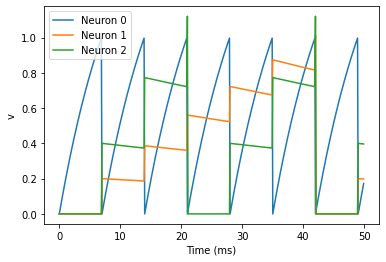

In [3]:
start_scope()

eqs = '''
dv/dt = (I-v)/tau : 1
I : 1
tau : second
'''
G = NeuronGroup(3, eqs, threshold='v>1', reset='v = 0', method='exact')
G.I = [2, 0, 0]
G.tau = [10, 100, 100]*ms

# Comment these two lines out to see what happens without Synapses
S = Synapses(G, G, 'w : 1', on_pre='v_post += w')
S.connect(i=0, j=[1, 2])
S.w = 'j*0.2'

M = StateMonitor(G, 'v', record=True)

run(50*ms)

plot(M.t/ms, M.v[0], label='Neuron 0')
plot(M.t/ms, M.v[1], label='Neuron 1')
plot(M.t/ms, M.v[2], label='Neuron 2')
xlabel('Time (ms)')
ylabel('v')
legend();

### Introducing a delay

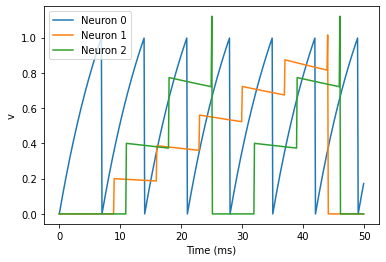

In [4]:
start_scope()

eqs = '''
dv/dt = (I-v)/tau : 1
I : 1
tau : second
'''
G = NeuronGroup(3, eqs, 
                threshold='v>1', 
                reset='v = 0', 
                method='exact')
G.I = [2, 0, 0]
G.tau = [10, 100, 100]*ms

# Comment these two lines out to see what happens without Synapses
S = Synapses(G, G, 'w : 1', on_pre='v_post += w')
S.connect(i=0, j=[1, 2])
S.w = 'j*0.2'
S.delay = 'j*2*ms'

M = StateMonitor(G, 'v', record=True)

run(50*ms)

plot(M.t/ms, M.v[0], label='Neuron 0')
plot(M.t/ms, M.v[1], label='Neuron 1')
plot(M.t/ms, M.v[2], label='Neuron 2')
xlabel('Time (ms)')
ylabel('v')
legend();

### More complex connectivity

In [5]:
start_scope()

N = 10
G = NeuronGroup(N, 'v:1')
S = Synapses(G, G)
S.connect(condition='i!=j', p=0.2)

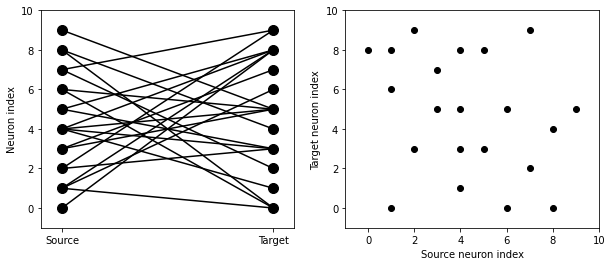

In [6]:
def visualise_connectivity(S):
    Ns = len(S.source)
    Nt = len(S.target)
    figure(figsize=(10, 4))
    subplot(121)
    plot(zeros(Ns), arange(Ns), 'ok', ms=10)
    plot(ones(Nt), arange(Nt), 'ok', ms=10)
    for i, j in zip(S.i, S.j):
        plot([0, 1], [i, j], '-k')
    xticks([0, 1], ['Source', 'Target'])
    ylabel('Neuron index')
    xlim(-0.1, 1.1)
    ylim(-1, max(Ns, Nt))
    subplot(122)
    plot(S.i, S.j, 'ok')
    xlim(-1, Ns)
    ylim(-1, Nt)
    xlabel('Source neuron index')
    ylabel('Target neuron index')

visualise_connectivity(S)

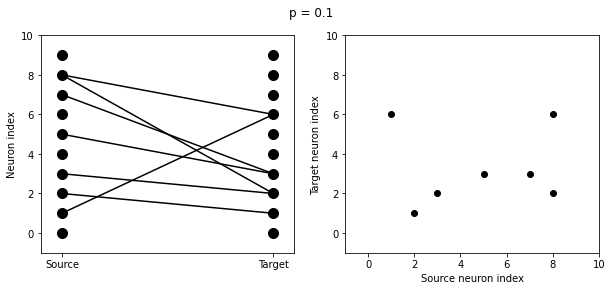

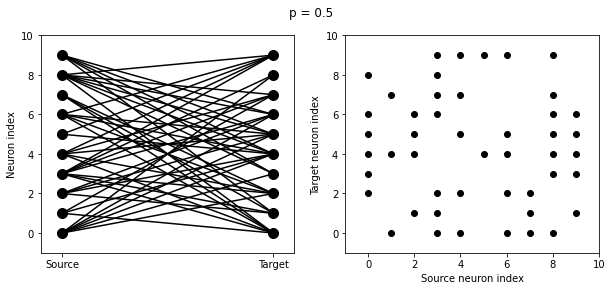

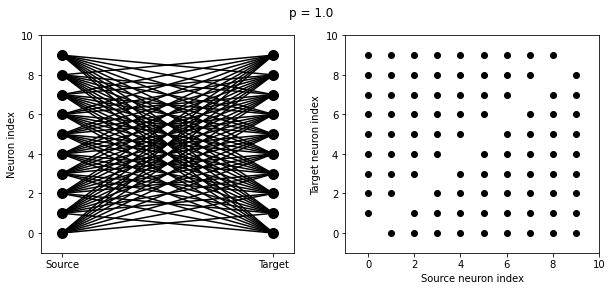

In [7]:
start_scope()

N = 10
G = NeuronGroup(N, 'v:1')

for p in [0.1, 0.5, 1.0]:
    S = Synapses(G, G)
    S.connect(condition='i!=j', p=p)
    visualise_connectivity(S)
    suptitle('p = '+str(p))

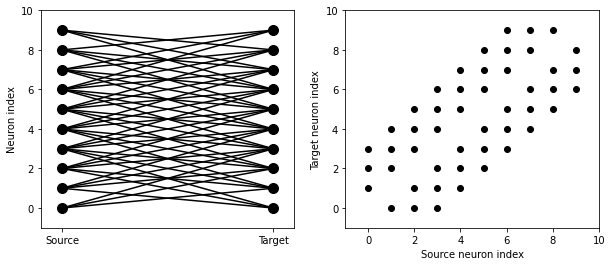

In [8]:
start_scope()

N = 10
G = NeuronGroup(N, 'v:1')

S = Synapses(G, G)
S.connect(condition='abs(i-j)<4 and i!=j')
visualise_connectivity(S)

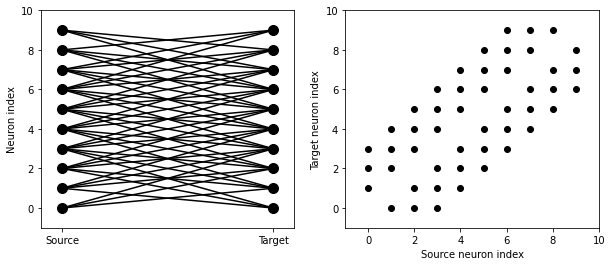

In [9]:
start_scope()
N=10
G=NeuronGroup(N, "v:1")
S=Synapses(G, G)
S.connect(j='k for k in range(i-3, i+4) if i!=k', 
          skip_if_invalid=True)
visualise_connectivity(S)

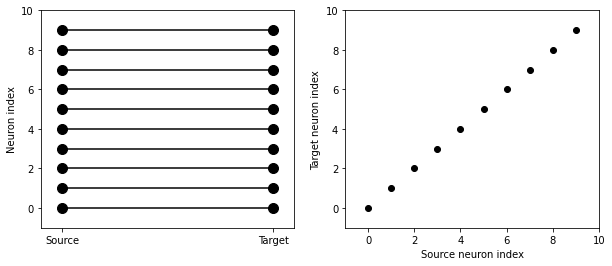

In [10]:
start_scope()

N = 10
G = NeuronGroup(N, 'v:1')

S = Synapses(G, G)
S.connect(j='i')
visualise_connectivity(S)

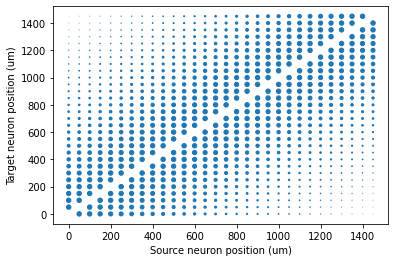

In [11]:
start_scope()

N = 30
neuron_spacing = 50*umetre
width = N/4.0*neuron_spacing

# Neuron has one variable x, its position
G = NeuronGroup(N, 'x : metre')
G.x = 'i*neuron_spacing'

# All synapses are connected (excluding self-connections)
S = Synapses(G, G, 'w : 1')
S.connect(condition='i!=j')
# Weight varies with distance
S.w = 'exp(-(x_pre-x_post)**2/(2*width**2))'

scatter(S.x_pre/um, S.x_post/um, S.w*20)
xlabel('Source neuron position (um)')
ylabel('Target neuron position (um)');

### More complex synapse models: STDP

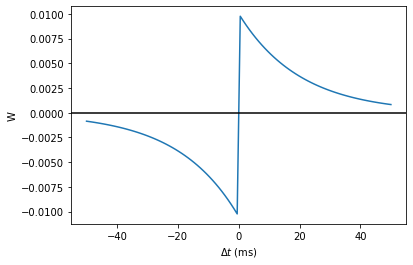

In [12]:
tau_pre = tau_post = 20*ms
A_pre = 0.01
A_post = -A_pre * 1.05
delta_t = linspace(-50, 50, 100) * ms
W = where(delta_t>0, A_pre*exp(-delta_t/tau_pre), 
          A_post * exp(delta_t/tau_post))
plot(delta_t/ms, W)
xlabel(r'$\Delta t$ (ms)')
ylabel('W')
axhline(0, ls='-', c='k');

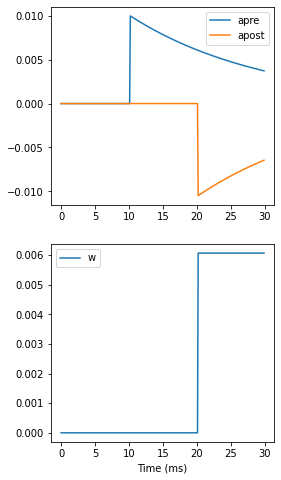

In [13]:
start_scope()

taupre = taupost = 20*ms
wmax = 0.01
Apre = 0.01
Apost = -Apre*taupre/taupost*1.05

G = NeuronGroup(2, 'v:1', 
                threshold='t>(1+i)*10*ms', 
                refractory=100*ms)

S = Synapses(G, G,
             '''
             w : 1
             dapre/dt = -apre/taupre : 1 (clock-driven)
             dapost/dt = -apost/taupost : 1 (clock-driven)
             ''',
             on_pre='''
             v_post += w
             apre += Apre
             w = clip(w+apost, 0, wmax)
             ''',
             on_post='''
             apost += Apost
             w = clip(w+apre, 0, wmax)
             ''', method='linear')
S.connect(i=0, j=1)
M = StateMonitor(S, ['w', 'apre', 'apost'], record=True)

run(30*ms)

figure(figsize=(4, 8))
subplot(211)
plot(M.t/ms, M.apre[0], label='apre')
plot(M.t/ms, M.apost[0], label='apost')
legend()
subplot(212)
plot(M.t/ms, M.w[0], label='w')
legend(loc='best')
xlabel('Time (ms)');

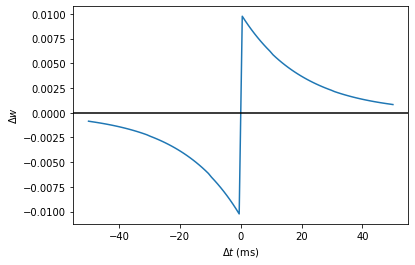

In [14]:
start_scope()

taupre = taupost = 20*ms
Apre = 0.01
Apost = -Apre*taupre/taupost*1.05
tmax = 50*ms
N = 100

# Presynaptic neurons G spike at times from 0 to tmax
# Postsynaptic neurons G spike at times from tmax to 0
# So difference in spike times will vary from -tmax to +tmax
G = NeuronGroup(N, 'tspike:second', threshold='t>tspike', refractory=100*ms)
H = NeuronGroup(N, 'tspike:second', threshold='t>tspike', refractory=100*ms)
G.tspike = 'i*tmax/(N-1)'
H.tspike = '(N-1-i)*tmax/(N-1)'

S = Synapses(G, H,
             '''
             w : 1
             dapre/dt = -apre/taupre : 1 (event-driven)
             dapost/dt = -apost/taupost : 1 (event-driven)
             ''',
             on_pre='''
             apre += Apre
             w = w+apost
             ''',
             on_post='''
             apost += Apost
             w = w+apre
             ''')
S.connect(j='i')

run(tmax+1*ms)

plot((H.tspike-G.tspike)/ms, S.w)
xlabel(r'$\Delta t$ (ms)')
ylabel(r'$\Delta w$')
axhline(0, ls='-', c='k');

#### practice connectivity

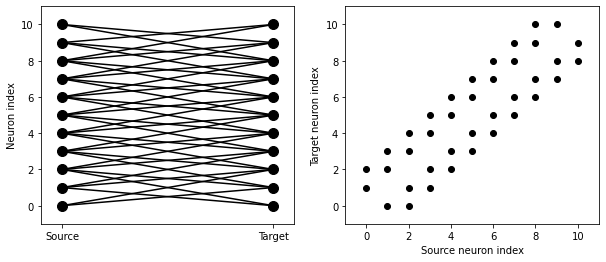

In [19]:
start_scope()

N = 11
G = NeuronGroup(N, 'v:1')

S = Synapses(G, G)
S.connect('(abs(i-j)<3) and (i!=j)')
visualise_connectivity(S)

In [43]:
import networkx as nx
N = 10
K = 3
G = nx.watts_strogatz_graph(N, K, 0, seed=1)
A = nx.to_numpy_array(G, dtype=int)
print(A)

[[0 1 0 0 0 0 0 0 0 1]
 [1 0 1 0 0 0 0 0 0 0]
 [0 1 0 1 0 0 0 0 0 0]
 [0 0 1 0 1 0 0 0 0 0]
 [0 0 0 1 0 1 0 0 0 0]
 [0 0 0 0 1 0 1 0 0 0]
 [0 0 0 0 0 1 0 1 0 0]
 [0 0 0 0 0 0 1 0 1 0]
 [0 0 0 0 0 0 0 1 0 1]
 [1 0 0 0 0 0 0 0 1 0]]


In [44]:
cols, rows = np.nonzero(A)

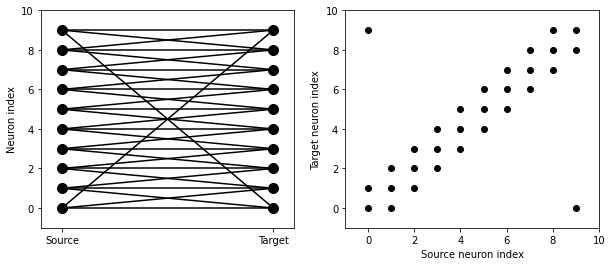

In [46]:
G = NeuronGroup(N, 'v:1')
S = Synapses(G, G)
S.connect(i=rows, j=cols)
S.connect(j='i')
visualise_connectivity(S)